## Let's build a TextCategorizer Model using spaCy

- This time the model will remove punctuaction and stopwords

In [ ]:
import pandas as pd 
import spacy
from spacy.tokens import Doc, DocBin
import os

In [ ]:
RUN_IN_COLAB = 'google.colab' in str(get_ipython())

In [ ]:
if RUN_IN_COLAB:
  !python -m spacy download de_core_news_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 567.8 MB 18 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [ ]:
# TODO: Remove
def load_model(name): 
    nlp = spacy.load(name)
    de_stop_words = nlp.Defaults.stop_words
    return nlp, de_stop_words

!mkdir -p ./data/processed/clean

In [ ]:
large_model = "de_core_news_lg"

nlp, stop_words = load_model(large_model)

In [ ]:
# Read training and dev datasets splits
BASE_PATH = os.path.join("./data/processed/clean")

def get_split(split, base_path=BASE_PATH): 
    return pd.read_csv(os.path.join(base_path, f"{split}.csv"))

In [ ]:
train_df = get_split(split="training")
train_df.head(3)

,text,tokens,tokens_norm,text_proc,cats,label
0,Blogs Foto Video Leserartikel Print-Archiv Sch...,"[Blogs, Foto, Video, Leserartikel, Print-Archi...","['blog', 'foto', 'video', 'leserartikel', 'pri...",blog foto video leserartikel print-archiv schl...,"{'tech': False, 'soft': False, 'none': True}",none
1,Braunschweig,[Braunschweig],['braunschweig'],braunschweig,"{'tech': False, 'soft': False, 'none': True}",none
2,Kenntnisse im Bereich Enterprise Architecture ...,"[Kenntnisse, im, Bereich, Enterprise, Architec...","['kenntnis', 'bereich', 'enterprise', 'archite...",kenntnis bereich enterprise architecture manag...,"{'tech': True, 'soft': False, 'none': False}",tech


In [ ]:
dev_df = get_split(split="dev")
dev_df.head(3)

,text,tokens,tokens_norm,text_proc,cats,label
0,"Kenntnisse in den Bereichen Gefahrgut, Ausfuhr...","[Kenntnisse, in, den, Bereichen, Gefahrgut, ,,...","['kenntnis', 'bereich', 'gefahrgut', 'ausfuhr'...",kenntnis bereich gefahrgut ausfuhr luftfracht ...,"{'tech': True, 'soft': False, 'none': False}",tech
1,Flexibler Umgang mit wechselnden Situationen s...,"[Flexibler, Umgang, mit, wechselnden, Situatio...","['flexibler', 'umgang', 'wechselnd', 'situatio...",flexibler umgang wechselnd situation hoch eins...,"{'tech': False, 'soft': True, 'none': False}",soft
2,Leipzig,[Leipzig],['leipzig'],leipzig,"{'tech': False, 'soft': False, 'none': True}",none


In [ ]:
test_df = get_split(split="test")
test_df.head(3)

,text,tokens,tokens_norm,text_proc,cats,label
0,Sie beherrschen Englisch in Wort und Schrift.,"[Sie, beherrschen, Englisch, in, Wort, und, Sc...","['beherrschen', 'englisch', 'wort', 'schrift']",beherrschen englisch wort schrift,"{'tech': False, 'soft': True, 'none': False}",soft
1,Zeig 12 mehr mitarbeitervorteile,"[Zeig, 12, mehr, mitarbeitervorteile]","['zeig', '12', 'mitarbeitervorteil']",zeig 12 mitarbeitervorteil,"{'tech': False, 'soft': False, 'none': True}",none
2,Organisations- und Verhandlungsgeschick sowie ...,"[Organisations-, und, Verhandlungsgeschick, so...","['organisation', 'verhandlungsgeschick', 'fund...",organisation verhandlungsgeschick fundiert fac...,"{'tech': False, 'soft': True, 'none': False}",soft


## Build the Binary Docs for Training

In [ ]:
# Let's process training data

def data_to_bindoc(df, split):
    docs = []
    for idx, doc in enumerate(nlp.pipe(df['text_proc'], batch_size=100)):
        doc.cats = eval(df.iloc[idx].cats)
        docs.append(doc)
            
    doc_bin = DocBin(docs=docs)
    data_path = f"./data/{split}_clean.spacy"
    doc_bin.to_disk(data_path)
    print(f"Proccesed and saved BinDoc for split:{split} to:{data_path}")

In [ ]:
%%time
data_to_bindoc(train_df, "train")

Proccesed and saved BinDoc for split:train to:./data/train_clean.spacy
CPU times: user 8.65 s, sys: 92.9 ms, total: 8.74 s
Wall time: 8.66 s


In [ ]:
%%time
data_to_bindoc(dev_df, "dev")

Proccesed and saved BinDoc for split:dev to:./data/dev_clean.spacy
CPU times: user 1.81 s, sys: 994 µs, total: 1.81 s
Wall time: 1.8 s


In [ ]:
data_to_bindoc(test_df, "test")

Proccesed and saved BinDoc for split:test to:./data/test_clean.spacy


## Process the config

In [ ]:
!python -m spacy init fill-config ./config/base_config_sw.cfg ./config/config_sw.cfg

✔ Auto-filled config with all values
✔ Saved config
config/config_sw.cfg
You can now add your data and train your pipeline:
python -m spacy train config_sw.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
! python -m spacy debug data ./config/config_sw.cfg


============================ Data file validation ============================
tcmalloc: large alloc 1200005120 bytes == 0x60984000 @  0x7f26835762a4 0x7f266269ee09 0x7f266269dcdf 0x7f266269a675 0x7f266269ae2e 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x7f25105e1d78 0x7f25105e470e 0x7f25105ec5a7 0x7f25105efe85 0x5d8d8c 0x55dc1e 0x5d8868 0x4990ca 0x7f25105e1d78 0x7f25105e470e 0x7f25105ebe4b 0x5d80be 0x5d8d8c 0x55ea20 0x55d078 0x5d8941 0x49abe4 0x55d078 0x5d8941 0x4997a2 0x55d078
tcmalloc: large alloc 1213743104 bytes == 0xcbe24000 @  0x7f26835762a4 0x7f266269c3a2 0x7f266269dcdf 0x7f266269a675 0x7f266269ae2e 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x5d8868 0x4997c7 0x7f25105e1d78 0x7f25105e470e 0x7f25105ebe4b 0x5d80be 0x5d8d8c 0x55ea20 0x55d078 0x5d8941 0x49abe4 0x55d078 0x5d8941 0x4997a2 0x55d078 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x5d8416 0x55f797
✔ Pipeline can be initialized with data
✔ Corpus is loadable

=============================== Training stats =====================

## Perform Training

In [ ]:
!python -m spacy train ./config/config_sw.cfg --gpu-id 0 --output textcat_clean

✔ Created output directory: textcat_clean
ℹ Saving to output directory: textcat_clean
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-12-22 18:15:41,457] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-12-22 18:15:41,469] [INFO] Pipeline: ['tok2vec', 'textcat']
INFO:spacy:Pipeline: ['tok2vec', 'textcat']
[2022-12-22 18:15:41,472] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-12-22 18:15:44,292] [INFO] Added vectors: de_core_news_lg
INFO:spacy:Added vectors: de_core_news_lg
tcmalloc: large alloc 1200005120 bytes == 0xa34fa000 @  0x7f5e62c192a4 0x7f5e41d46e09 0x7f5e41d45cdf 0x7f5e41d42675 0x7f5e41d42e2e 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x7f5cc5c79d78 0x7f5cc5c7c70e 0x7f5cc5c845a7 0x7f5cc5c87e85 0x5d8d8c 0x55dc1e 0x5d8868 0x4990ca 0x7f5cc5c79d78 0x7f5cc5c7c70e 0x7f5cc5c83e4b 0x5d80be 0x5d8d8c 0x55ea20 0x55d078 0x5d8941 0x49abe4 0x4fe253 0x49abe4 0x55d078 0x5d8941
tcmalloc: l

## Evaluate


Let's load the best model and try to evaluate on a single example

In [ ]:
nlp = spacy.load("textcat_clean/model-best")

doc = nlp("Kenntnisse im Bereich Online-Dienste von Vorteil")
doc.cats

{'tech': 0.9884323477745056,
 'soft': 0.004672237206250429,
 'none': 0.0068954057060182095}

### Evaluate using spacy evaluate

In [ ]:
!python -m spacy evaluate textcat_clean/model-best/ ./data/test_clean.spacy --output textcat_clean/evaluate.json

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   89.29 
SPEED               2236  


=========================== Textcat F (per label) ===========================

           P       R       F
tech   86.01   86.27   86.14
soft   91.84   86.54   89.11
none   92.79   92.47   92.63


======================== Textcat ROC AUC (per label) ========================

       ROC AUC
tech      0.97
soft      0.97
none      0.98

✔ Saved results to textcat_clean/evaluate.json


In [ ]:
# Save best model
!tar -czvf best_model_clean.tar.gz textcat_clean/model-best/* textcat_clean/evaluate.json

textcat_clean/model-best/config.cfg
textcat_clean/model-best/meta.json
textcat_clean/model-best/textcat/
textcat_clean/model-best/textcat/cfg
textcat_clean/model-best/textcat/model
textcat_clean/model-best/tok2vec/
textcat_clean/model-best/tok2vec/cfg
textcat_clean/model-best/tok2vec/model
textcat_clean/model-best/tokenizer
textcat_clean/model-best/vocab/
textcat_clean/model-best/vocab/key2row
textcat_clean/model-best/vocab/strings.json
textcat_clean/model-best/vocab/lookups.bin
textcat_clean/model-best/vocab/vectors
textcat_clean/model-best/vocab/vectors.cfg
textcat_clean/evaluate.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
save_to = "/content/drive/MyDrive/tb_challenge/"
!cp best_model_clean.tar.gz $save_to

## Obtain Predictions from Text Data

In [ ]:
best_model = "./textcat_clean/model-best/"
test_data = "./data/test_clean.spacy"

In [ ]:
nlp = spacy.load(best_model)
docs = DocBin().from_disk(test_data)

In [ ]:
def get_key(d, value):
  return next((k for k, v in d.items() if v == value), None) 

In [ ]:
idx_to_label = {0: "tech", 1: "soft", 2: "none"}
label_to_idx = {"tech": 0, "soft": 1, "none": 2}

In [ ]:
def get_preds_and_gold(nlp, docs):
  """
  Created this function to be able to create the confusion matrix
  """
  preds, gold = [], []
  for doc in docs.get_docs(nlp.vocab):
    true_label = get_key(doc.cats, True)
    doc = nlp(doc.text )
    pred_label = max(doc.cats, key=doc.cats.get)
    preds.append(label_to_idx[pred_label])
    gold.append(label_to_idx[true_label])
  return preds, gold 

In [ ]:
preds, gold = get_preds_and_gold(nlp, docs)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
gold_arr, pred_arr = np.array(gold), np.array(preds)
gold_arr.shape, pred_arr.shape

((1401,), (1401,))

In [ ]:
def plot_matrix(y_preds, gold, labels): 
  c_matrix = confusion_matrix(y_true=gold, y_pred=y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(8,8))
  display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix,
                                          display_labels=labels)
  display_matrix.plot(cmap="RdPu",values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion Matrix for spaCy Clean model")
  plt.show()

In [ ]:
classes = ["soft","tech","none"]

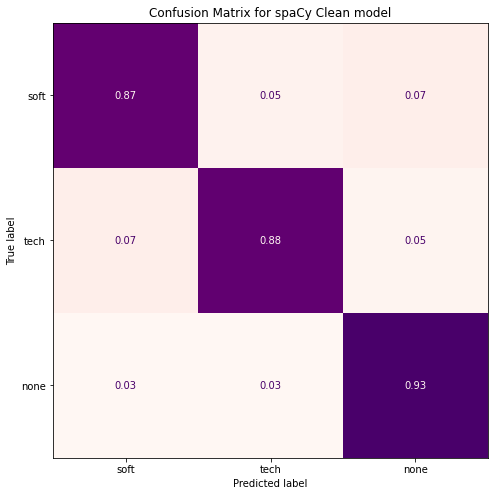

In [ ]:
plot_matrix(pred_arr, gold_arr, classes)